# Disease Prediction Models Comparison

In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
import gc  # Garbage collector for memory management
import time
import sys
import joblib

## 1. Load dataset

In [33]:
print("Loading dataset...")
# Change this path to match your file location
symptoms_disease_df = pd.read_csv('../data/Final_Augmented_dataset_Diseases_and_Symptoms.csv')
print(f"Dataset shape: {symptoms_disease_df.shape}")

# Identify disease column and symptoms
disease_column = symptoms_disease_df.columns[0]
symptom_columns = symptoms_disease_df.drop(disease_column, axis=1).columns

print(f"Number of symptom features: {len(symptom_columns)}")
print(f"Number of unique diseases: {symptoms_disease_df[disease_column].nunique()}")

# Get counts of diseases to understand class distribution
disease_counts = symptoms_disease_df[disease_column].value_counts()
print(f"Most common disease appears {disease_counts.max()} times")
print(f"Least common disease appears {disease_counts.min()} times")

Loading dataset...
Dataset shape: (246945, 378)
Number of symptom features: 377
Number of unique diseases: 773
Most common disease appears 1219 times
Least common disease appears 1 times


## 2. Prepare data with feature selection

In [30]:
# Select the most frequent symptoms to reduce dimensionality
symptom_counts = symptoms_disease_df[symptom_columns].sum().sort_values(ascending=False)
top_symptoms = symptom_counts.head(300).index.tolist()
print(f"Using top {len(top_symptoms)} most frequent symptoms out of {len(symptom_columns)}")

# Create train/test datasets
X = symptoms_disease_df[top_symptoms]  # Only use top symptoms
y = symptoms_disease_df[disease_column]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Free up memory
del symptoms_disease_df
gc.collect()

Using top 300 most frequent symptoms out of 377
Training set: (197556, 300), Test set: (49389, 300)


2225

## 3. Define helper function for model evaluation

In [12]:
def get_size_mb(obj):
    """Get approximate size of an object in MB"""
    return sys.getsizeof(obj) / (1024 * 1024)

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """Train, evaluate and time a model"""
    # Training
    print(f"\nTraining {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Prediction time
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Summarize
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Training time: {train_time:.2f} seconds")
    print(f"  Prediction time: {predict_time:.4f} seconds")
    
    return {
        "name": name,
        "model": model,
        "accuracy": accuracy,
        "train_time": train_time,
        "predict_time": predict_time,
    }

# Set up results storage
results = []

## 4. Evaluate Decision Tree

In [13]:
# Train and evaluate Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=25,              # Deeper tree for better accuracy
    min_samples_split=5,       # Avoid overfitting
    min_samples_leaf=2,        # Avoid overfitting
    class_weight='balanced',   # Handle class imbalance
    random_state=42
)

dt_results = evaluate_model("Decision Tree", dt_model, X_train, y_train, X_test, y_test)
results.append(dt_results)


Training Decision Tree...
Decision Tree:
  Accuracy: 0.0587 (5.87%)
  Training time: 2.82 seconds
  Prediction time: 0.1355 seconds


## 5. Evaluate Multinomial Naive Bayes

In [14]:
# Train and evaluate Multinomial Naive Bayes
nb_model = MultinomialNB(alpha=0.1)  # Lower alpha for this binary data

nb_results = evaluate_model("Multinomial Naive Bayes", nb_model, X_train, y_train, X_test, y_test)
results.append(nb_results)


Training Multinomial Naive Bayes...
Multinomial Naive Bayes:
  Accuracy: 0.8555 (85.55%)
  Training time: 167.49 seconds
  Prediction time: 0.2012 seconds


## 6. Evaluate KNN

In [15]:
# Train and evaluate KNN
knn_model = KNeighborsClassifier(
    n_neighbors=5,      # Number of neighbors to consider
    weights='distance',  # Weight by distance for better accuracy
    algorithm='auto',    # Let sklearn choose the fastest algorithm
    n_jobs=-1           # Use all cores
)

knn_results = evaluate_model("K-Nearest Neighbors", knn_model, X_train, y_train, X_test, y_test)
results.append(knn_results)


Training K-Nearest Neighbors...
K-Nearest Neighbors:
  Accuracy: 0.8138 (81.38%)
  Training time: 0.21 seconds
  Prediction time: 126.4341 seconds


## 7. Evaluate SGD Classifier

In [16]:
# Train and evaluate SGD Classifier
sgd_model = SGDClassifier(
    loss='log_loss',     # Logistic regression loss
    penalty='l2',        # L2 regularization
    alpha=0.0001,        # Regularization strength
    max_iter=1000,       # Increased iterations for convergence
    tol=1e-3,            # Tolerance for stopping criterion
    random_state=42,
    n_jobs=-1
)

sgd_results = evaluate_model("SGD Classifier", sgd_model, X_train, y_train, X_test, y_test)
results.append(sgd_results)


Training SGD Classifier...
SGD Classifier:
  Accuracy: 0.8343 (83.43%)
  Training time: 89.42 seconds
  Prediction time: 0.2195 seconds


## 8. Results Comparison

In [17]:
# Create comparison table
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df[['name', 'accuracy', 'train_time', 'predict_time']]
comparison_df['accuracy'] = comparison_df['accuracy'] * 100  # Convert to percentage

# Format for display
display_df = comparison_df.copy()
display_df['accuracy'] = display_df['accuracy'].map('{:.2f}%'.format)
display_df['train_time'] = display_df['train_time'].map('{:.2f} sec'.format)
display_df['predict_time'] = display_df['predict_time'].map('{:.4f} sec'.format)
display_df.set_index('name', inplace=True)
display_df.columns = ['Accuracy', 'Training Time', 'Prediction Time']

# Display sorted by accuracy
print("Models sorted by accuracy:")
display_df.sort_values('Accuracy', ascending=False)

Models sorted by accuracy:


,Accuracy,Training Time,Prediction Time
name,,,
Multinomial Naive Bayes,85.55%,167.49 sec,0.2012 sec
SGD Classifier,83.43%,89.42 sec,0.2195 sec
K-Nearest Neighbors,81.38%,0.21 sec,126.4341 sec
Decision Tree,5.87%,2.82 sec,0.1355 sec


## 9. Select and analyze best model

In [19]:
# Find best model based on accuracy
best_idx = comparison_df['accuracy'].idxmax()
best_model_results = results[best_idx]
best_model = best_model_results['model']
best_model_name = best_model_results['name']

print(f"\nBest model: {best_model_name}")
print(f"Accuracy: {best_model_results['accuracy']:.2f}%")
print(f"Training time: {best_model_results['train_time']:.2f} seconds")


Best model: Multinomial Naive Bayes
Accuracy: 0.86%
Training time: 167.49 seconds


## 10. Detailed Evaluation of Best Model

In [25]:
# Predict with best model
y_pred = best_model.predict(X_test)

# Evaluate accuracy for top diseases
top_disease_counts = y.value_counts().head(20)
top_diseases = top_disease_counts.index
mask = y_test.isin(top_diseases)

if mask.sum() > 0:
    top_accuracy = accuracy_score(y_test[mask], y_pred[mask])
    print(f"\nAccuracy for top 20 most common diseases: {top_accuracy:.4f} ({top_accuracy*100:.2f}%)")

# Get summary metrics
print("\nDetailed metrics for the best model:")
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print(f"Weighted average precision: {report_dict['weighted avg']['precision']:.4f}")
print(f"Weighted average recall:    {report_dict['weighted avg']['recall']:.4f}")
print(f"Weighted average F1-score:  {report_dict['weighted avg']['f1-score']:.4f}")


Accuracy for top 20 most common diseases: 0.8456 (84.56%)

Detailed metrics for the best model:
Weighted average precision: 0.8626
Weighted average recall:    0.8555
Weighted average F1-score:  0.8536


## 11. Create prediction function for the best model

In [ ]:
def predict_disease(symptoms_input, model, feature_list):
    """Create a prediction for given symptoms"""
    # Create input dataframe with zeros
    input_data = pd.DataFrame(0, index=[0], columns=feature_list)
    
    # Set symptoms that are present
    matched_symptoms = []
    for symptom in symptoms_input:
        if symptom in input_data.columns:
            input_data[symptom] = 1
            matched_symptoms.append(symptom)
    
    # Check if any symptoms matched
    if not matched_symptoms:
        return "No matching symptoms found in the model's feature set", [], []
    
    # Make prediction
    predicted_disease = model.predict(input_data)[0]
    
    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(input_data)[0]
        top_indices = probabilities.argsort()[-3:][::-1]
        top_diseases = [model.classes_[i] for i in top_indices]
        top_probs = [probabilities[i] for i in top_indices]
        return predicted_disease, top_diseases, top_probs
    
    # For models that don't have predict_proba
    return predicted_disease, [predicted_disease], [1.0]

# Test the prediction function
test_cases = [
    ['headache', 'fever', 'cough'],
    ['sharp abdominal pain', 'nausea', 'vomiting'],
    ['back pain', 'shortness of breath', 'dizziness']
]

print("\nExample predictions with the best model:")
for i, symptoms in enumerate(test_cases):
    print(f"\nCase {i+1}: Patient with symptoms: {', '.join(symptoms)}")
    try:
        predicted_disease, top_diseases, top_probs = predict_disease(symptoms, best_model, top_symptoms)
        
        if isinstance(predicted_disease, str) and predicted_disease.startswith("No matching"):
            print(f"  {predicted_disease}")
        else:
            print(f"  Predicted disease: {predicted_disease}")
            print("  Top predictions:")
            for j, (disease, prob) in enumerate(zip(top_diseases, top_probs)):
                if hasattr(best_model, 'predict_proba'):
                    print(f"    {j+1}. {disease} (Confidence: {prob:.4f})")
                else:
                    print(f"    {j+1}. {disease}")
    except Exception as e:
        print(f"  Error in prediction: {e}")


Example predictions with the best model:

Case 1: Patient with symptoms: headache, fever, cough
  Predicted disease: acute bronchitis
  Top predictions:
    1. acute bronchitis (Confidence: 0.1051)
    2. chronic sinusitis (Confidence: 0.0997)
    3. flu (Confidence: 0.0964)

Case 2: Patient with symptoms: sharp abdominal pain, nausea, vomiting
  Predicted disease: pyelonephritis
  Top predictions:
    1. pyelonephritis (Confidence: 0.0335)
    2. gastrointestinal hemorrhage (Confidence: 0.0309)
    3. fluid overload (Confidence: 0.0304)

Case 3: Patient with symptoms: back pain, shortness of breath, dizziness
  Predicted disease: magnesium deficiency
  Top predictions:
    1. magnesium deficiency (Confidence: 0.0648)
    2. myasthenia gravis (Confidence: 0.0511)
    3. poisoning due to gas (Confidence: 0.0496)


## 12. Export the Best Model

In [ ]:
# Save the best model
print(f"\nSaving the best model ({best_model_name})...")
joblib.dump(best_model, f'disease_prediction_{best_model_name.lower().replace(" ", "_")}.joblib', compress=9)
print(f"Model saved successfully")

# Also save the fastest good model if different
if fastest_model_results['name'] != best_model_name:
    fastest_model = fastest_model_results['model']
    print(f"\nSaving the fastest good model ({fastest_model_results['name']})...")
    joblib.dump(fastest_model, f'disease_prediction_{fastest_model_results["name"].lower().replace(" ", "_")}.joblib', compress=9)
    print(f"Fast model saved successfully")

# Save the feature list
pd.Series(top_symptoms).to_csv('model_features.csv', index=False, header=['feature'])
print("Feature list saved as 'model_features.csv'")


Saving the best model (Multinomial Naive Bayes)...
Model saved successfully

Saving the fastest good model (K-Nearest Neighbors)...
Fast model saved successfully
Feature list saved as 'model_features.csv'


## 13. Test Model Loading

In [ ]:
# Clear memory
del best_model
if 'fastest_model' in locals():
    del fastest_model
gc.collect()

# Test loading the best model
print(f"\nTesting model loading...")
start_time = time.time()
model_file = f'disease_prediction_{best_model_name.lower().replace(" ", "_")}.joblib'
loaded_model = joblib.load(model_file)
load_time = time.time() - start_time

print(f"Model loaded successfully in {load_time:.2f} seconds")

# Verify predictions work
test_input = pd.DataFrame(0, index=[0], columns=top_symptoms)
test_input.iloc[0, 0:3] = 1  # Set first three symptoms to 1
prediction = loaded_model.predict(test_input)[0]
print(f"Test prediction: {prediction}")


Testing model loading...
Model loaded successfully in 0.01 seconds
Test prediction: gastritis


## 14. Visulization

Using top 300 most frequent symptoms out of 377
Training set: (197540, 300), Test set: (49386, 300)


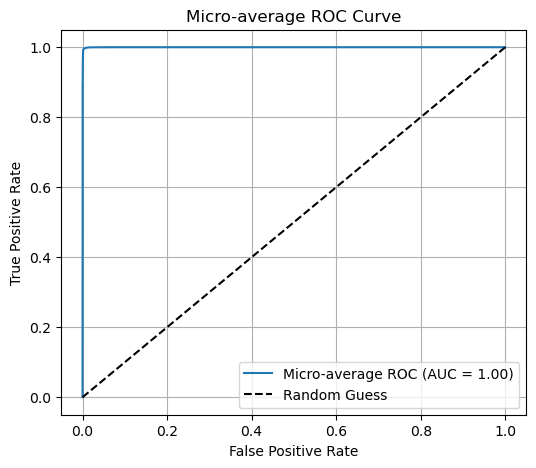

In [35]:
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.metrics import roc_curve, auc

# Select the most frequent symptoms to reduce dimensionality
symptom_counts = symptoms_disease_df[symptom_columns].sum().sort_values(ascending=False)
top_symptoms = symptom_counts.head(300).index.tolist()
print(f"Using top {len(top_symptoms)} most frequent symptoms out of {len(symptom_columns)}")

# Create feature matrix X and target vector y using top symptoms only
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 2].index

X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

# Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Free up memory
del symptoms_disease_df
gc.collect()

# Train a fresh Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict probability scores on the new test set
y_score = model.predict_proba(X_test)

# Encode class labels and align with model outputs
label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # Use training set labels to define class order
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode test labels using the label classes
y_test_bin = label_binarize(y_test_encoded, classes=np.arange(len(label_encoder.classes_)))

# Compute the micro-average ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Micro-average ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-average ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [39]:
import joblib
model = joblib.load("disease_prediction_multinomial_naive_bayes.joblib")
y_pred = model.predict(X_test)

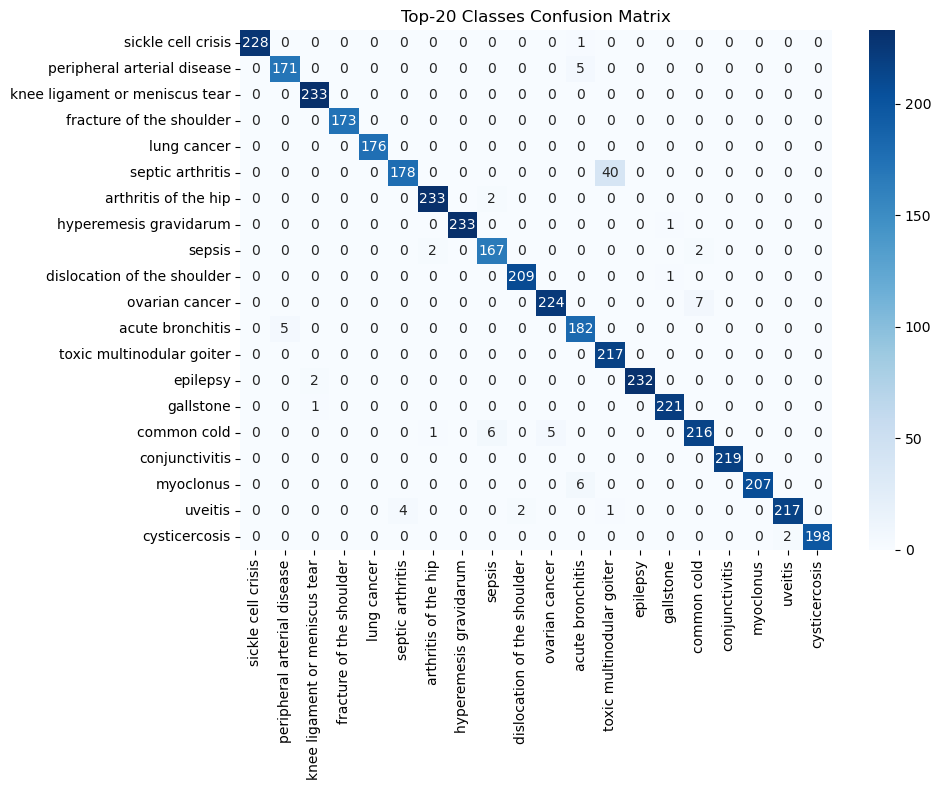

In [43]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = model.classes_
support = cm.sum(axis=1)
top_k_idx = np.argsort(support)[-20:]

cm_top = cm[top_k_idx][:, top_k_idx]
labels_top = [labels[i] for i in top_k_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_top, annot=True, fmt="d", cmap="Blues", xticklabels=labels_top, yticklabels=labels_top)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Top-20 Classes Confusion Matrix")
plt.tight_layout()
plt.show()

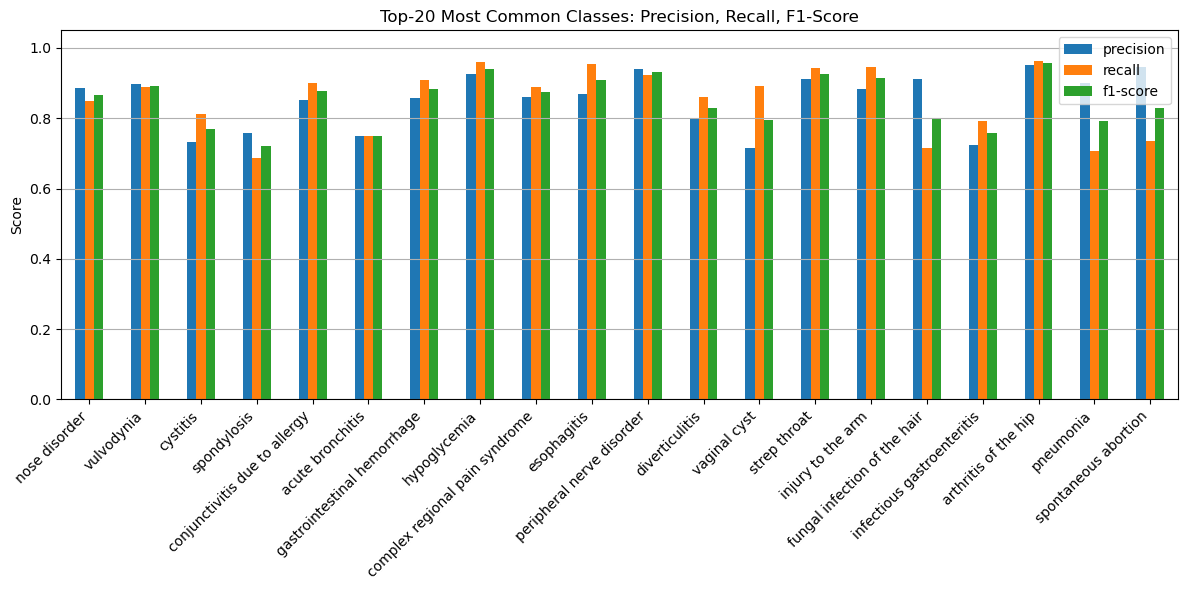

In [56]:
from collections import Counter

used_classes = sorted(list(set(y_test) | set(y_pred)))
used_labels = [label for label in model.classes_ if label in used_classes]

report = classification_report(
    y_test,
    y_pred,
    labels=used_classes,
    target_names=used_labels,
    output_dict=True,
    zero_division=0
)

report_df = pd.DataFrame(report).transpose()

support_count = Counter(y_test)
top20_classes = [label for label, _ in support_count.most_common(20)]
top20_indices = [used_labels.index(label) for label in top20_classes]
metrics_df = report_df.iloc[top20_indices][['precision', 'recall', 'f1-score']]

# Plot precision, recall, and f1-score for each class
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Top-20 Most Common Classes: Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()